# **Introduction**

The CIRIGHTS (Cingranelli-Richards) human rights dataset is a comprehensive resource that contains information regarding state respect for a variety of human rights across countries, from 1981 to 2021. It includes measures of physical integrity rights (such as protection from torture, extrajudicial killings, political imprisonment, and disappearance) and civil liberties (such as freedom of speech, assembly, and movement). By coding these rights on ordinal scales derived from a combination of quantitative and qualitative assessments, CIRIGHTS enables researchers to track trends, compare performance across nations, and evaluate the effects of domestic and international policies on human rights conditions. The dataset spans decades, making it particularly valuable for longitudinal analyses and cross-national comparisons.

This dataset addresses critical social science questions, such as: What factors contribute to the deterioration or improvement of human rights in different contexts? It is also widely used to assess the impact of events such as democratization and civil conflict. By providing a standardized framework for analyzing human rights practices, CIRIGHTS helps researchers to explore the mechanisms underlying rights violations.

In particular, I will be using this dataset to answer the question: How well does the level of respect states have for civil liberties and other related measures predict for states' level of respect for physical integrity rights?

# **Initializing Dataset and Loading Necessary Libraries**

In [ ]:
# Giving google colab access to my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading libraries and reading in excel file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels
import sklearn

# Reading in the dataset

data = pd.read_excel('/content/drive/MyDrive/cirights.xlsx')
data.head()

,country,year,ciri,cow,polity,unctry,unreg,unsubreg,human_rights_score,physint_sum,...,wosoc_l,union_l,barg_l,hour_l,force_l,child_l,wage_l,safe_l,trafficking_l,trial_l
0,Canada,1981,194,20,20,124.0,21,21,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,Qatar,1981,524,694,694,634.0,142,145,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Rwanda,1981,533,517,517,646.0,2,14,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,Afghanistan,1981,101,700,700,4.0,142,62,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,Equatorial Guinea,1981,269,411,411,226.0,2,17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


Since there are no entries for the target variable before 2005, it is best to drop all observations before 2005. Therefore, each country will have at most 15 human rights observations for each year, from 2005-2021. Note also that human_rights_score for the years 2020 and 2021 are empty for virtually all countries.

In [ ]:
# Drop observations before 2005
data = data.drop(data[data['year'] <= 2004].index)

# Check length of data
len(data)

3304

This is still an acceptable number of observations in the dataset for when it is split into training and testing sets to the build the predictive models.

# **Data Pre-Processing and Scaling**

The main goal of this section is to account for the large numbers of missing observations across columns of the dataset and prepare it for model-building.

In [ ]:
# Check where most of the NaN values lie by variable
data.isna().sum()

,0
country,0
year,0
ciri,0
cow,0
polity,0
unctry,27
unreg,0
unsubreg,0
human_rights_score,999
physint_sum,15


Since human_rights_score is an additive index of the other variables, there will be high multicollinearity if we use any of these associated variables in the model. Similarly, I will drop all of the sum variables except physint_sum, since this is the target variable.

In [ ]:
# Drop the following variables to prevent multicollinearity issues
data = data.drop(columns = ['human_rights_score', 'repression_sum', 'civpol_sum', 'workerrights_practices_sum', 'workerrights_laws_sum', 'bbatrocity'])

# And, since physint_sum is an additive index of disap, kill, polpris, and tort we must drop these as well since they inform the target variable
# Also dropping bbatrocity_intensity since it has too many missing values
data = data.drop(columns = ['disap', 'kill', 'polpris', 'tort', 'bbatrocity_intensity'])

I also don't need the *unique* identifiers for each state (as this can lead to overfitting), so I will drop them as well. Additionally, year is not helpful for a generalizable prediction, either. Note unreg (UN Region) and unsubreg (UN Subregion) are not unique to each state, so I will keep them in the dataset

In [ ]:
# Drop unique identifier variables
data = data.drop(columns=['country', 'year', 'ciri', 'cow', 'polity', 'unctry'])

In [ ]:
# Now let's see how many missing values there are in proportion to the size of the dataset (3304 observations in total)
data.isna().sum()

,0
unreg,0
unsubreg,0
physint_sum,15
assn,40
formov,232
dommov,39
speech,35
elecsd,35
rel_free,229
wecon,422


Now I want to see which columns have more than 330 missing values (more than 10% missing, because it is risky to impute for variables that have more than 10% of the data missing). If this is the case, I want to drop all observations that have NaNs for those specific columns of interest only, i.e. we are not dropping all NaNs in the whole dataset.

In [ ]:
# Identify columns with more than 330 missing values
columns_with_many_nans = data.columns[data.isna().sum() > 330]

# Drop rows where ONLY the identified columns have NaN values
for col in columns_with_many_nans:
    data = data[~data[col].isna()]

# Reset the index
data.reset_index(drop=True, inplace=True)

In [ ]:
# Check that the size of the dataset is still sufficient
len(data)

2343

There are still over 2300 observations, which is an acceptable size for this dataset, since there are about 30-35 variables total now.

In [ ]:
# Check for proportions of missing values again
data.isna().sum()

,0
unreg,0
unsubreg,0
physint_sum,4
assn,5
formov,2
dommov,4
speech,1
elecsd,1
rel_free,1
wecon,0


Notice that the highest proportion of missing values for any column is 22, which is only 0.938967136% of the dataset. Therefore, I can safely impute for the rest of the variables without worrying about the data being biased.


Most of the variables with NaNs are ordinal categorical based on fixed numeric values in the following way:


0: over 100 instances of the event described by the variable

1: between 50-100 instances of the event described by the variable

2: 49 or fewer instances of the event described by the variable


Those that do not fall into this scale have a similar ordinal categorical measure of 0 or 1.


In summary, all of these variables with NaNs are ordinal categorical data, which I can impute with the mean, the closest metric to the average for this type of data.


In [ ]:
# The rest of the variables with NaNs are categorical (taking on values of 0, 1, or 2) so we will impute using the median
column_list = data.columns.tolist()

for col in column_list:
  if data[col].isna().sum() > 0:
    data[col].fillna(data[col].median(), inplace = True)


<ipython-input-11-88ec245ba56b>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace = True)


In [ ]:
# Now check to make sure that there are no NaNs in the dataset
data.isna().sum()

,0
unreg,0
unsubreg,0
physint_sum,0
assn,0
formov,0
dommov,0
speech,0
elecsd,0
rel_free,0
wecon,0


Now that we have successfully contained the missing observations, I must check to make sure each variable has the appropriate datatype for model building. As they are ordinal categorical, I need them to be integer values.

In [ ]:
# Check the dataypes of each column to make sure they are in the appropriate format
data.dtypes

,0
unreg,int64
unsubreg,int64
physint_sum,float64
assn,float64
formov,float64
dommov,float64
speech,float64
elecsd,float64
rel_free,float64
wecon,float64


Clearly, many variables are floats when they should only be integers, as they are measured on an integer scale, so let's fix this


In [ ]:
# These columns' data are already in the correct format
excluded_cols = ['unreg', 'unsubreg']

# Not that all of these columns are in float format, but should be integers
included_cols = [col for col in data.columns if col not in excluded_cols]

for col in included_cols:
  data[col] = pd.to_numeric(data[col], downcast='integer')

# Check again to make sure changes were made
data.dtypes

,0
unreg,int64
unsubreg,int64
physint_sum,int8
assn,int8
formov,int8
dommov,int8
speech,int8
elecsd,int8
rel_free,int8
wecon,int8


The final general preprocessing consideration to make here is that the target variable, physint_sum, which characterizes how well states respect bodily autonomy of civilians, has an additive score randing from 0 to 8, which is likely too many categories for a decently accurate prediction, as there is only a 1 point difference separating each category. As such, I will create a new target variable from physint_sum that bins the original range into a reduced 3 categories. They will be as follows:


0: physint_sum score of 0-2


1: physint_sum score of 3-5


2: physint_sum score of 6-8

In [ ]:
# Defining bins ranges
bins = [0, 2, 5, 9]
labels = [0, 1, 2]   # Labels for the bins (0 for 0-2, 1 for 3-5, 2 for 6-8)

# Create a new target variable
data['physint_target'] = pd.cut(data['physint_sum'], bins=bins, labels=labels, right=False)

# Convert the 'physint_binned' column to integer type
data['physint_target'] = data['physint_target'].astype(int)

# Display the first few rows to check the result
print(data[['physint_sum', 'physint_target']].head())

   physint_sum  physint_target
0            5               2
1            4               1
2            4               1
3            5               2
4            8               2


# **Model Building**

The goal of this section is to begin with a basic linear model for classification, and then assess the various accuracy metrics after fitting this model to justify the modification of the initial approach until I arrive at 2 baseline models that yield satisfactory premilimary accuracy before hyperparameter tuning.

##Loading Necessary Libraries for Model Building

In [ ]:
!pip install mglearn
import mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import graphviz

## Logistic Regression Model

As I am not immediately sure what variety of classification models is optimal for my dataset, I will begin with a basic logistic regression model and work my way up from the preliminary results of this model to build 2 baseline models that are apt for hyperparameter tuning.

**Basic Logistic Regression Model**

First, I must scale my feature variable dataset, which I will do after splitting it into training and testing sets.


Scaling helps prevent the algorithm from placing undue importance to features with larger magnitudes simply because of their scale, rather than their actual relevance. Though most of my data is scaled identically (they take on values in {0, 1, 2}, there are a couple of variables scaled only such that they take on values in {0, 1}, so I am scaling as an extra precaution.


Scaling should occur *after* the train/test splitting because if scaling is applied before this, information about the test data (e.g., its mean or variance) leaks into the training data. This can lead to overly optimistic performance estimates, as the model has indirectly "seen" the test data.

In [ ]:
# Delineate the set of feature variables, X, and the target variable, y

# Note physint_sum is the variable that physint_target was built off of, so I have to remove this from all X sets as well
X = data.drop(columns=['physint_target', 'physint_sum'])
y = data['physint_target'].astype(int)

# Split the data to build model using training sets and evaluate using testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Standardize the features (fit on training set only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Note that I do not standardize the target variable sets (y_train, y_test) because it is a categorical variable. Additionally, the test set must be scaled using the same mean and standard deviation as the training set to ensure that the model evaluates unseen data under the same conditions it was trained on. Therefore, we use fit_transform to get the scaling parameters for X_train (which is being used to build the model), which is then applied to X_test during evaluation.

In [ ]:
# Fit logistic regression model on scaled features set
logr = LogisticRegression(random_state=30)
logr.fit(X_train_scaled, y_train)

# Evaluate the model on the training set
prediction_train = logr.predict(X_train_scaled)

# Evaluate the model on the test set
prediction_test = logr.predict(X_test_scaled)

Now that I have built the model and evaluated it on both within-sample and out-of-sample data, I can compare the accuracies on both sets, and also look more in-depth into the classification abilities of the model on the test set.

In [ ]:
print(f"Training Set Accuracy: {accuracy_score(y_train, prediction_train):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, prediction_test):.2f}")

# Retrieve the classification report and accuracy scores for training and testing sets
print("\nClassification Report (Basic Logistic Regression):")
print(classification_report(y_test, prediction_test))

# Check model coefficients to find most influential variables in prediction
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logr.coef_[0]
})
print(coefficients.sort_values(by='Coefficient', ascending = False))

Training Set Accuracy: 0.77
Test Set Accuracy: 0.78

Classification Report (Basic Logistic Regression):
              precision    recall  f1-score   support

           0       0.66      0.43      0.52        44
           1       0.61      0.59      0.60       117
           2       0.86      0.91      0.88       308

    accuracy                           0.78       469
   macro avg       0.71      0.64      0.67       469
weighted avg       0.78      0.78      0.78       469

          Feature  Coefficient
21        trial_p     0.125657
0           unreg     0.124950
24         barg_l     0.123391
13         hour_p     0.117819
5          speech     0.086360
26        force_l     0.031556
6          elecsd     0.018872
28         wage_l     0.014152
22        wosoc_l     0.005902
9           wopol    -0.015934
31        trial_l    -0.034546
17         safe_p    -0.038250
30  trafficking_l    -0.047525
18  trafficking_p    -0.052409
2            assn    -0.055019
29         safe_l  

The model achieves good performance, with a training set accuracy of 0.77 and a slightly lower test set accuracy of 0.78, indicating that it generalizes reasonably well without significant overfitting. Class 2 is predicted with high precision (0.86), recall (0.91), and F1-score (0.88), reflecting the model's strong capability to identify the majority class. For Classes 0 and 1, performance is more moderate: Class 0 has a precision of 0.66 and a recall of 0.43, resulting in an F1-score of 0.52, indicating the model struggles to correctly identify many instances of this class. Similarly, while Class 1 has precision (0.61) and recall (0.59), the F1-score of 0.60 suggests room for improvement in capturing all actual Class 1 instances. Overall, the macro-average metrics (precision: 0.71, recall: 0.64, F1: 0.77) highlight the model's varied performance across classes, while the weighted-average metrics reflect its strong emphasis on the majority class.


Looking at the model coefficients, trial_p has the highest positive coefficient (about 0.126), indicating that it is the most influential predictor of the target variable. unreg and barg_l also contribute positively with similar effects, suggesting their impact is about as important as trial_p. This can be interpreted as the better trial practices a state has, the more likely it is to have high respect for physical integrity rights, which seems intuitive.


On the negative side, ngo_freedom has the largest negative coefficient (-0.80), suggesting a significant inverse relationship, followed by other features like child_p and wecon, which have moderate negative impacts. This makes sense- as NGO freedom or union laws deteriorate, it might be more likely that a country is also engaging in acitivity such as forced imprisonment or torture, increasing its physical integrity rights violations, and vice versa.


This spread of coefficients highlights the dominant influence of a few key features while many others play a more subtle role in the model's predictions. Their magnitudes are also small in general, but many have much smaller magnitudes overall, indicating that they could be potentially irrelevant or removed from the model.

**Marginally Improved Logistic Regression Model?**

As hinted at above, the basic logistic regression model is best at predicting Class 2, which the class that the majority of observations fall into. This uneven distribution for the target variable can lead to eroded predictive power, so to remedy this, I can stratify over the classes of the target variable when splitting our data into training and testing sets. This ensures that the distribution of target classes is preserved in both the training and testing datasets, typically improving model evaluation.

In [ ]:
# Note that there is some imbalance in the distribution across the target variable values:
category_counts = data['physint_target'].value_counts()
print(category_counts)

physint_target
2    1452
1     650
0     241
Name: count, dtype: int64


In [ ]:
# Let's add stratification to see if this improves our baseline model

# Split the data with stratified sampling
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, test_size=0.2, stratify=y, random_state= 30)

# Standardize features sets according to fit on X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_strat)
X_test_scaled = scaler.transform(X_test_strat)

# Fit logistic regression model on scaled features set
logr_strat = LogisticRegression(random_state=30)
logr_strat.fit(X_train_scaled, y_train_strat)

# Evaluate the model on the training set
prediction_train_strat = logr_strat.predict(X_train_scaled)

# Evaluate the model on the test set
prediction_test_strat = logr_strat.predict(X_test_scaled)

# Retrieve the classification report and accuracy scores for training and testing sets

print(f"Training Set Accuracy: {accuracy_score(y_train_strat, prediction_train_strat):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test_strat, prediction_test_strat):.2f}")

print("\nClassification Report(Logistic Regression with Stratification):")
print(classification_report(y_test_strat, prediction_test_strat))

# Check model coefficients to find most influential variables in prediction
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logr_strat.coef_[0]
})
print(coefficients.sort_values(by='Coefficient', ascending = False))

Training Set Accuracy: 0.78
Test Set Accuracy: 0.77

Classification Report(Logistic Regression with Stratification):
              precision    recall  f1-score   support

           0       0.68      0.40      0.50        48
           1       0.62      0.64      0.63       130
           2       0.84      0.89      0.87       291

    accuracy                           0.77       469
   macro avg       0.72      0.64      0.67       469
weighted avg       0.77      0.77      0.76       469

          Feature  Coefficient
13         hour_p     0.168653
21        trial_p     0.151994
28         wage_l     0.131702
0           unreg     0.100792
22        wosoc_l     0.085516
24         barg_l     0.061718
5          speech     0.044339
26        force_l     0.037009
6          elecsd     0.015311
31        trial_l     0.004852
9           wopol    -0.002724
2            assn    -0.038860
27        child_l    -0.059571
19          injud    -0.068900
29         safe_l    -0.075842
30  tr

This did not improve the basic model, so it seems as though the imbalance is not a major issue hindering predictive power, so we do not need to incorporate stratification for this model.

In fact, let's just run the basic logr model on the stratified X_test and y_test to see if accuracy improves.

In [ ]:
# Evaluate the model on the training set
prediction_train_strat = logr.predict(X_train_scaled)

# Evaluate the model on the test set
prediction_test_strat = logr.predict(X_test_scaled)

# Retrieve the classification report and accuracy scores for training and testing sets

print(f"Training Set Accuracy: {accuracy_score(y_train_strat, prediction_train_strat):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test_strat, prediction_test_strat):.2f}")

print("\nClassification Report(Logistic Regression with Stratification):")
print(classification_report(y_test_strat, prediction_test_strat))

# Check model coefficients to find most influential variables in prediction
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logr.coef_[0]
})
print(coefficients.sort_values(by='Coefficient', ascending = False))

Training Set Accuracy: 0.77
Test Set Accuracy: 0.79

Classification Report(Logistic Regression with Stratification):
              precision    recall  f1-score   support

           0       0.69      0.46      0.55        48
           1       0.65      0.67      0.66       130
           2       0.87      0.90      0.89       291

    accuracy                           0.79       469
   macro avg       0.73      0.68      0.70       469
weighted avg       0.79      0.79      0.79       469

          Feature  Coefficient
21        trial_p     0.125657
0           unreg     0.124950
24         barg_l     0.123391
13         hour_p     0.117819
5          speech     0.086360
26        force_l     0.031556
6          elecsd     0.018872
28         wage_l     0.014152
22        wosoc_l     0.005902
9           wopol    -0.015934
31        trial_l    -0.034546
17         safe_p    -0.038250
30  trafficking_l    -0.047525
18  trafficking_p    -0.052409
2            assn    -0.055019
29    

Although the overall improvement in accuracy was only about 1 percent for the test set, other, more significant improvements have been made across other metrics such as precision and recall, which is surprising, considering that I have used the model (logr) fit without stratification to evaluate stratified X and y test sets. Classes 0 and 1 show substantial improvements in precision, recall, and F1-score, suggesting that stratification helped the model better learn from this underrepresented class. Importantly, Class 2 performance remained strong, with minor gains in precision and F1-score, showing that the improvements for minority classes did not come at the cost of majority class performance. The macro-average metrics (precision, recall, F1-score) improved, highlighting more balanced performance across all classes. This demonstrates that logr is a better model than logr_strat.

**Logistic Regression Model with PCA**

An potential downside of this model that is important to consider is the high number of feature variables (32). As such, building a linear model with coefficients for all 32 variables can not only be difficult to interpret, but it means that there might be some additional noise as a result of fully utilizing features that may offer very little predictive power, and can even lead to overfitting. Of course, it is difficult to manually determine which variables capture the most important relationships in the data.


To solve this issue, I will use Principal Components Analysis because it reduces the dimensionality of the dataset, capturing the most important patterns in the data while discarding noise and less relevant features.

Explained Variance Ratio of First 3 Principal Components: [0.33471111 0.07253895 0.04918906]
Total Explained Variance Across all 3 Principal Components: 0.46


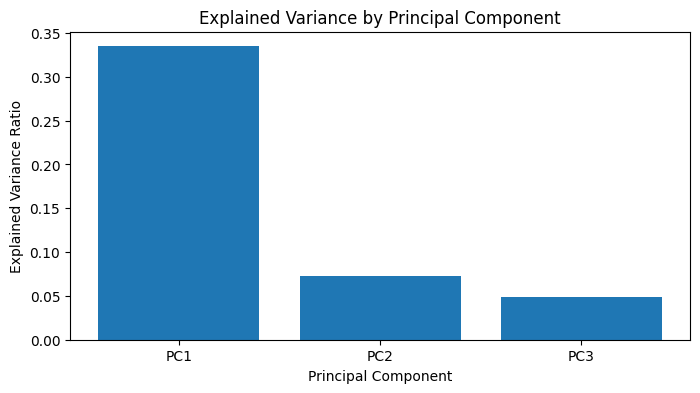

In [ ]:
# Split the data to build model using training sets and evaluate using testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Standardize the features (fit on training set only)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to the standardized training data, use first 3 principal components
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate explained variance of the 3 principal components
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio of First 3 Principal Components:", explained_variance)
print(f"Total Explained Variance Across all 3 Principal Components: {sum(explained_variance):.2f}")

# Plotting explained variance ratio of each principal component
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, tick_label=[f"PC{i}" for i in range(1, len(explained_variance) + 1)])
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Component")
plt.show()

Clearly, the total explained variance for the first 3 principal components is quite low at 46%, which the first principal component explaining far more variation (33.5%) than the second and third.


Since the first 3 components explain only 46% of the variance, the remaining variability is spread across other components. This suggests that the dataset is relatively high-dimensional, with variability distributed across many features. This is likely because the categorical nature of the features (e.g. values of 0, 1, or 2) limits the variability that can be captured by PCA. These discrete values may not exhibit strong linear correlations, making it harder for PCA to capture a significant portion of the variance in a few principal components.

Still, I can fit a logistic regression model using the first 3 principal componenents to confirm this intuition. I expect most of the classification scores to decrease compared the the previous baseline model.

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Fit Logistic Regression model on the principal components
logr_pca = LogisticRegression(random_state=30)
logr_pca.fit(X_train_pca, y_train)

# Evaluate the model on the training set
prediction_train_pca = logr_pca.predict(X_train_pca)

# Evaluate the model on the test set
prediction_test_pca = logr_pca.predict(X_test_pca)

# Retrieve the classification report and accuracy scores for training and testing sets
print(f"Training Set Accuracy: {accuracy_score(y_train, prediction_train_pca):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, prediction_test_pca):.2f}")

print("\nClassification Report(Logistic Regression with PCA):")
print(classification_report(y_test, prediction_test_pca))

Training Set Accuracy: 0.73
Test Set Accuracy: 0.77

Classification Report(Logistic Regression with PCA):
              precision    recall  f1-score   support

           0       0.83      0.34      0.48        44
           1       0.57      0.58      0.57       117
           2       0.84      0.90      0.87       308

    accuracy                           0.77       469
   macro avg       0.75      0.61      0.64       469
weighted avg       0.77      0.77      0.76       469



This confirms my earlier intuition, as the only metric that improved was the precision score for Class 0, while most metrics saw a score decrease, while overall accuracy was virtually unchanged.


Therefore, PCA is not a reasonable approach for this linear model, and as of now, the most promising baseline model is the basic logistic regression.

However, I am still left with the same problem as before- an excess number of features in the dataset that may be contributing more noise than predictive power to the model. I need a method to reduce the number of features in the dataset from 32 down to a number that is more tractable. A promising way to solve this would be to introduce an L1 penalty that sends certain insignificant coefficients to 0, thereby performing the necessary feature reduction. This is is a LASSO Model of Logistic Regression.

**LASSO (L1 Regluarization) Logistic Regression for Feature Selection**

Since I have 32 features in the dataset, many with very small coefficient magnitudes as per the output from the previous model, LASSO can effectively identify and retain only the most relevant features, reducing the complexity of the model. This helps improve interpretability, mitigate overfitting, and potentially enhance predictive performance by focusing on the variables that contribute meaningfully to the outcome.

In [ ]:
# Fit LASSO model on the training data- setting a baseline L1 penalty of 0.1 for now
logr_lasso = LogisticRegression(penalty='l1', solver='saga', random_state=30, max_iter=10000, C=0.1)
logr_lasso.fit(X_train_scaled, y_train)

# Evaluate the model on the training set
prediction_train_lasso = logr_lasso.predict(X_train_scaled)

# Evaluate the model on the test set
prediction_test_lasso = logr_lasso.predict(X_test_scaled)

# Retrieve the classification report and accuracy scores for training and testing sets
print(f"Training Set Accuracy: {accuracy_score(y_train, prediction_train_lasso):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, prediction_test_lasso):.2f}")

print("Classification Report (LASSO Regression):")
print(classification_report(y_test, prediction_test_lasso))

# Feature selection analysis- checkiing which coefficients were retained, and their magnitides
feature_names = X.columns
coefficients = logr_lasso.coef_[0]

# Filter features with coefficients > 0
selected_features = [(feature, coef) for feature, coef in zip(feature_names, coefficients) if coef != 0]

print(f"Number of Selected Features: {len(selected_features)}")
print("Selected Features and Coefficients:")
for feature, coef in selected_features:
    print(f"{feature}: {coef:.4f}")

Training Set Accuracy: 0.77
Test Set Accuracy: 0.78
Classification Report (LASSO Regression):
              precision    recall  f1-score   support

           0       0.63      0.27      0.38        44
           1       0.60      0.64      0.62       117
           2       0.86      0.91      0.89       308

    accuracy                           0.78       469
   macro avg       0.70      0.61      0.63       469
weighted avg       0.78      0.78      0.77       469

Number of Selected Features: 11
Selected Features and Coefficients:
formov: -0.0644
dommov: -0.1149
rel_free: -0.0650
wecon: -0.0879
wosoc_p: -0.0916
union_p: -0.1755
force_p: -0.0353
child_p: -0.4906
ngo_freedom: -0.6225
safe_l: -0.0183
trafficking_l: -0.0027


The decrease in performance scores after applying LASSO, as seen in the classification reports, stems from LASSO's tendency to shrink coefficients and eliminate features with small contributions. While this simplifies the model and enhances interpretability, it also risks removing features that collectively contribute to performance, particularly for minority classes. This is evident in the lower recall and F1-scores for Classes 0 and 1 in the LASSO report compared to standard logistic regression with stratification. Conversely, Class 2, the majority class, remains relatively unaffected, as LASSO retains features that strongly predict this dominant class. The trade-off here is between simplicity and performance: using all 32 features ensures that the model captures the broader set of weaker signals needed for minority classes, but at the cost of interpretability.


The question now is whether to simply use standard logstic regression with stratification and retain all 32 features so that satisfactory minority class prediction can be maintained, or LASSO is the better choice due to ease in interpretability as a result of feature reduction.

Because my goal is to maximize predictive performance across all classes, particularly for the minority ones, retaining all 32 features is the better choice, as it ensures that subtle contributions from multiple features are not lost. Additionally, I want to maximize the recall score, as it is important that of the states that are actually committing the most violations, the model is correctly capturing a high proportion of these as positive instances of Class 0. In other words, I want to minimize false negatives, because falsely predicting a country to have a higher score than it does can have serious negative implications for human rights- if attention is not paid to countries with in Class 0 because the model predicts wrongly that they are in Class 2, for example, this can cost human lives. That is why I want to make sure the recall score for Class 0 is maximized, while also balancing the scores for other metrics.

Therefore, the baseline linear model should be first basic logsitic regression model that was fit.

**Basline Logistic Regression Model**

In [ ]:
# Set the baseline model for hyperparameter tuning in the next section
logr_baseline = LogisticRegression(random_state=30)
logr_baseline.fit(X_train_scaled, y_train)

LogisticRegression(random_state=30)

## Random Forest Model

To complement the logistic regression model, I will also try to fit a random forest model on the data, as it can address some shortcomings of logistic regression.


 Unlike logistic regression, which assumes linear relationships between features and the target, random forests can capture complex, nonlinear patterns, making them more flexible for modeling real-world data. They also naturally handle feature interactions and higher-order dependencies, which logistic regression cannot account for without explicit inclusion. Random forests work well with categorical variables, like those in my dataset, without requiring extensive preprocessing (e.g. no need for scaling). Additionally, they provide insights into feature importance, guiding feature selection and regularization in logistic models. Their ensemble nature also makes them more resistant to overfitting and noise.

**Basic Random Forest Model**

Training Set Accuracy: 1.00
Test Set Accuracy: 0.84
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        44
           1       0.68      0.69      0.68       117
           2       0.89      0.93      0.91       308

    accuracy                           0.84       469
   macro avg       0.83      0.74      0.77       469
weighted avg       0.84      0.84      0.83       469



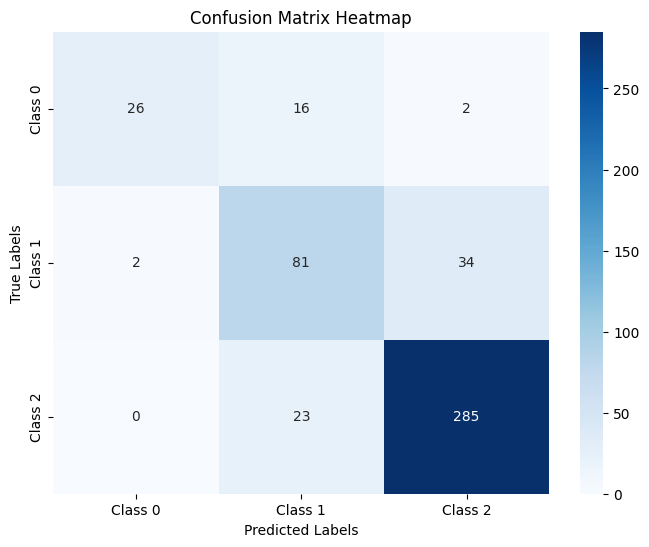

In [ ]:
# Initialize the Random Forest model
# Note that this is a very basic model that will essentially act like a decision tree before I begin modifying it
forest = RandomForestClassifier(random_state=30)

# Fit the model with the target variable 'y'
forest.fit(X_train, y_train)

# Evalute the model on the training set
prediction_train = forest.predict(X_train)

# Evalute the model on the training set
prediction_test = forest.predict(X_test)

# Retrieve the classification report and accuracy scores for training and testing sets
print(f"Training Set Accuracy: {accuracy_score(y_train, prediction_train):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, prediction_test):.2f}")

print("Classification Report (Random Forest):")
print(classification_report(y_test, prediction_test))

# Confusion matrix and heatmap
cm = confusion_matrix(y_test, prediction_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The random forest model, even acting as a single decision tree, outperforms logistic regression in several areas, particularly in handling minority classes. Precision, recall, and F1-scores for Classes 0 and 1 improve (especially for Class 0), indicating better identification of true positives and fewer false positives for these underrepresented classes. The majority class (Class 2) also sees slight gains in performance, reflecting the random forest's ability to capture complex, nonlinear relationships in the data.

The perfect training accuracy indicates that the single decision tree used here is overfitting to the training data. This is expected since decision trees, without bootstrapping or pruning, tend to memorize the training set. I will fix this during hyperparameter tuning.

**Marginally Improved Random Forest Model?**

Before more in-depth hyperparameter tuning, I can introduce basic additions to the model, particularly boostrapping. This ensures that each decision tree in the forest is trained on a different bootstrap sample, introducing variation in the training data for each tree. In turn, this helps to reduce overfitting, as no single tree sees the entire dataset, encouraging the ensemble to learn diverse patterns.

Training Set Accuracy: 1.00
Test Set Accuracy: 0.84
Classification Report (Random Forest with Boostrapping):
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        44
           1       0.68      0.69      0.68       117
           2       0.89      0.93      0.91       308

    accuracy                           0.84       469
   macro avg       0.83      0.74      0.77       469
weighted avg       0.84      0.84      0.83       469



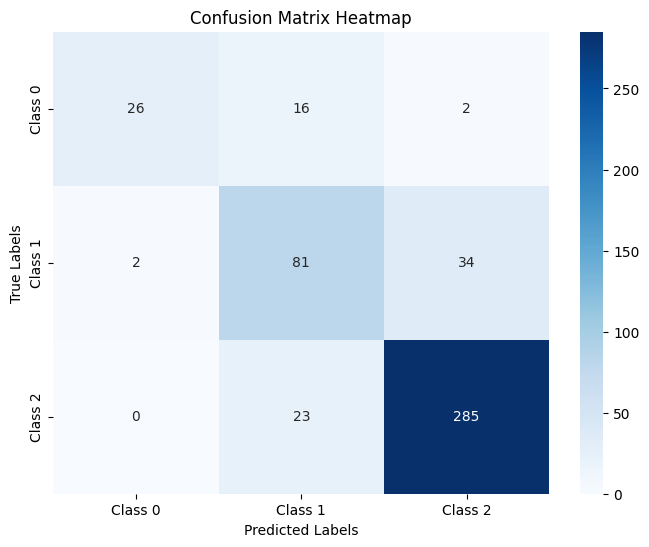

In [ ]:
# Using bootstrapping with class weights to see if I can achieve a better baseline random forest

# Fit the random forest with bootstrap = True
forest_weighted = RandomForestClassifier(bootstrap = True, random_state=30)
forest_weighted.fit(X_train, y_train)

# Evaluate the model on training and test sets
prediction_train_weighted = forest_weighted.predict(X_train)
prediction_test_weighted = forest_weighted.predict(X_test)

# Retrieve the classification report and accuracy scores for training and testing sets
print(f"Training Set Accuracy: {accuracy_score(y_train, prediction_train_weighted):.2f}")
print(f"Test Set Accuracy: {accuracy_score(y_test, prediction_test_weighted):.2f}")

print("Classification Report (Random Forest with Boostrapping):")
print(classification_report(y_test, prediction_test_weighted))

# Confusion matrix and heatmap
cm = confusion_matrix(y_test, prediction_test_weighted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


The random forest with bootstrapping has the exact same scores for all classification metric as the earlier single decision tree model. The training accuracy remains perfect at 1.00 still, since I have not specified a max_depth, so when being fit on the training data, the trees in the forest keep building until they have successfully classified all the training data.

Overall, even though it is not entirely clear which model is most best, the inclusion of bootstrapping generally reduces overfitting and increases model generalizability, making the random forest more robust and effective. Additionally, the recall scores have not diminished, which is what I want to pay special attention to when building the model.

For best practices reasons, then, the baseline random forest I will use for hyperparameter tuning in the next section will include boostrapping.

**Baseline Random Forest Model**

In [ ]:
forest_baseline = RandomForestClassifier(bootstrap = True, random_state=30)
forest_baseline.fit(X_train, y_train)

RandomForestClassifier(random_state=30)

# **Hyperparameter Tuning**

The goal of this section is to find the optimal combination of parameters and their specific values such that the model's predictive power is maximized. I will first do so for the logr_baseline model, and then for the forest_baseline model.

First, below is a function I will use to evaluate the accuracy metrics of the models that have been optimally tuned for comparison with the baseline.

In [ ]:
# Evaluate each model
def evaluation(model, name, X, y):
    print(f"\nClassification Report ({name}):")
    print(classification_report(y, model.predict(X)))
    print(f"{name} Accuracy: {accuracy_score(y, model.predict(X)):.4f}")


## Tuning the Logistic Regression Model

The selected parameters for tuning the logistic regression model focus on optimizing its regularization, convergence, and computational efficiency. The C parameter controls the strength of regularization, with values ranging from strong (small C) to weak (large C), ensuring a thorough exploration of the balance between overfitting and underfitting. The max_iter parameter specifies the maximum number of iterations for optimization, and the tol parameter fine-tunes the stopping criteria for the optimization process. Since this is a multiclass classification problem, I also want to test different strategies for handling this, hence my inclusion of the multi_class parameter. For the solver, I chose saga because it supports both multinomial and one-vs-rest strategies for multiclass classification, both of which I wanted to use for tuning. I also decided to see whether balancing the class weights improve accuracy with any of these combinations, as it did not work previously with the baseline model.

In [ ]:
# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],
    'max_iter': [1000, 5000],
    'solver': ['saga'],
    'tol': [1e-4, 1e-3],
    'penalty': ['l1', 'l2', None],
    'class_weight': ['balanced', None],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Initialize with the logistic regression baseline model
grid_search = GridSearchCV(
    estimator=logr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Perform GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Extract GridSearchCV results
all_scores = grid_search.cv_results_["mean_test_score"]
all_params = grid_search.cv_results_["params"]

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Now, an assessment of the best, worst, and the baseline model can be done to see how the best combination of parameters compares to that of other parameter combinations.

In [ ]:
# Find the best model (highest score)
optimal_logr_index = all_scores.argmax()
optimal_logr = grid_search.best_estimator_
optimal_logr_params = all_params[optimal_logr_index]
optimal_logr_score = all_scores[optimal_logr_index]

# Find the worst model (lowest score)
worst_logr_index = all_scores.argmin()
worst_logr_params = all_params[worst_logr_index]
worst_logr = grid_search.estimator.set_params(**worst_logr_params)
worst_logr.fit(X_train_scaled, y_train)

# Print parameter combinations and values for each model
print("\nModel Parameters")
print(f"Optimal Model Parameters: {optimal_logr_params}")
print(f"Worst Model Parameters: {worst_logr_params}")

# Evaluate the best, worst, and random models
print("\nModel Evaluation")
evaluation(logr_baseline, "Baseline Model", X_test_scaled, y_test)
evaluation(optimal_logr, "Optimal Model", X_test_scaled, y_test)
evaluation(worst_logr, "Worst Model", X_test_scaled, y_test)


Model Parameters
Optimal Model Parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'saga', 'tol': 0.0001}
Worst Model Parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}

Model Evaluation

Classification Report (Baseline Model):
              precision    recall  f1-score   support

           0       0.66      0.43      0.52        44
           1       0.61      0.59      0.60       117
           2       0.86      0.91      0.88       308

    accuracy                           0.78       469
   macro avg       0.71      0.64      0.67       469
weighted avg       0.78      0.78      0.78       469

Baseline Model Accuracy: 0.7846

Classification Report (Optimal Model):
              precision    recall  f1-score   support

           0       0.61      0.32      0.42        44
           1       0.60      0.60      0.60       117
 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: 

The optimal model outperformed the worst model but slightly underperformed compared to the baseline. The optimal model achieved similar overall accuracy (0.7804) to the baseline (0.7846) and maintained strong performance for the majority class (2) with an f1-score of 0.88. However, it sacrificed performance for the minority class (0), with its recall dropping to 0.32 compared to 0.43 in the baseline, which is the metric I want to maximize. The precision for Class 0 also fell by 0.05, which presents further issues with correctly predicting states committing the worst physical integrity abuses.The worst model performed significantly worse (accuracy = 0.2495), failing to predict classes 0 and 2 entirely due to excessive regularization (C=0.001), the sparsity-inducing l1 penalty, and overemphasis on class balancing.

The differences highlight the importance of balancing regularization strength and penalty type. The optimal model used weaker regularization (C=0.1) and the L2 penalty, which preserved relevant features and maintained generalization. In contrast, the worst model's strong regularization (0.001) and L1 penalty likely discarded essential features, leading to poor performance. Class weighting (class_weight='balanced') in the worst model caused it to overly prioritize one of the minority classes (1), achieving perfect recall at the expense of others. The results suggest that the baseline model offers better balance across classes, while the optimal model provides a viable alternative for fine-tuned performance.

###Choosing the Final Logistic Regression Model

Before choosing the final model, if the classification reports on the test set for both models are extremely similar, my first step would be to cross validate the baseline logistic regression model and compare the mean classification scores on the test set from the 5-fold cross validation of this baseline to that of the model that was found to be the best via hyperparameter tuning (note also that this model was found to be the "best" using its cross validation mean test accuracy score when hyperparameter tuning).

However, because the recall score for Class 0 on the test set for optimal_logr was significantly poorer than the baseline model (a decrease of 0.11), it is likely that this issue of a lower recall will persist when I report the classification metrics from 5-fold cross validation. At least, there is a sufficiently low chance of an 0.11 boost in recall for Class 0 in the 5-fold CV classification results. Seeing that the results of the other scoring metrics (precision, accuracy, etc.) across both model versions are quite similar, I argue that it is best to choose the basline logistic regression model as the final model here. Had the recall of the model obtained by hyperparameter tuning been higher for Class 0, which is the metric I am especially concerned with maximizing, I would have run the 5-fold CV on both models to see which one is more robust to data changes. Additionally, since the rest of the values in the classification reports on the test set are similar, I conjecture that their cross validation scores would have been very similar as well, so there is no severe risk of choosing the "worst" model of the two.

Thus, the final parameters chosen will be that of the baseline model, some of which are as follows:

The baseline model is a Logistic Regression model built using default settings. It uses the 'lbfgs' solver, a robust optimization algorithm suitable for multiclass classification and smaller datasets. Regularization is applied through the default 'l2' penalty to prevent overfitting by penalizing large coefficients, with a regularization strength parameter (C) set to 1.0, indicating moderate regularization. The model allows for a maximum of 100 iterations (max_iter) for the solver to converge. Additionally, the multi_class parameter is set to 'auto', enabling it to select the appropriate strategy for handling binary or multiclass problems (defaulting to 'ovr' for binary classification and 'multinomial' otherwise). This simple yet effective configuration enabled the baseline model to achieve the highest predictive power compared to the more complex models, suggesting that its straightforward design was well-suited to the dataset and avoided unnecessary overfitting.

In [ ]:
final_logr = LogisticRegression(random_state=30)
final_logr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=30)

## Tuning the Random Forest Model

The parameters chosen for tuning are max_features, n_estimators, max_depth, min_samples_split, and min_samples_leaf.

These parameters are well-suited to optimizing the performance of forest_baseline by targeting key aspects of random forest behavior. Parameters like max_features determine the number of features considered at each split, balancing randomness and relevance, while n_estimators specifies the number of trees in the ensemble, influencing overall model stability. Max_depth controls how deep each tree can grow, managing the trade-off between capturing complex patterns and avoiding overfitting. Additionally, min_samples_split and min_samples_leaf define the minimum number of samples required for splitting nodes and forming leaf nodes, ensuring the model maintains sufficient generalization while avoiding overly simplistic splits. These parameters are critical for tailoring the random forest to the dataset's size, structure, and complexity, enabling it to effectively capture meaningful patterns.

In [ ]:
# Define the parameter grid
param_grid = {
    'max_features': ['sqrt', 0.5, 0.8],
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 5-fold cross-validation
grid_search = GridSearchCV(
    estimator = forest_baseline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on the training data
grid_search.fit(X_train, y_train)

# Extract results
all_scores = grid_search.cv_results_["mean_test_score"]
all_params = grid_search.cv_results_["params"]


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Now, an assessment of the best, worst, and the baseline model can be done to see how the best combination of parameters compares to that of other parameter combinations.

In [ ]:
# Find the best model (highest score)
optimal_forest_index = all_scores.argmax()
optimal_forest = grid_search.best_estimator_
optimal_forest_params = all_params[optimal_forest_index]
optimal_forest_score = all_scores[optimal_forest_index]

# Find the worst model (lowest score)
worst_forest_index = all_scores.argmin()
worst_forest_params = all_params[worst_forest_index]
worst_forest = grid_search.estimator.set_params(**worst_forest_params)
worst_forest.fit(X_train, y_train)

# Print parameter combinations and values for each model
print("\nModel Parameters")
print(f"Optimal Model Parameters: {optimal_forest_params}")
print(f"Worst Model Parameters: {worst_forest_params}")

# Evaluate the best, worst, and random models
print("\nModel Evaluation")
evaluation(forest_baseline, "Baseline Model", X_test, y_test)
evaluation(optimal_forest, "Optimal Model", X_test, y_test)
evaluation(worst_forest, "Worst Model", X_test, y_test)



Model Parameters
Optimal Model Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Worst Model Parameters: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Model Evaluation

Classification Report (Baseline Model):
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        44
           1       0.68      0.69      0.68       117
           2       0.89      0.93      0.91       308

    accuracy                           0.84       469
   macro avg       0.83      0.74      0.77       469
weighted avg       0.84      0.84      0.83       469

Baseline Model Accuracy: 0.8358

Classification Report (Optimal Model):
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        44
           1       0.69      0.69      0.69       117
           2       0.89      0.93      

The optimal model, with parameters such as a maximum depth of 20, sqrt for max_features, and 200 estimators, emphasizes flexibility and a comprehensive search across feature subsets during splits. In contrast, the worst model, constrained by a maximum depth of 10, a fixed 0.8 for max_features, and fewer estimators (100), limits the model’s ability to capture complex patterns and interact with feature space diversity. The optimal model uses smaller values for min_samples_leaf (1 vs. 4) and min_samples_split (2 vs. 10), allowing it to create deeper and more finely tuned splits, which increases its flexibility to capture complex patterns, while the worst model imposes stricter thresholds that prevent overfitting but may underfit the data.These differences likely contributed to the optimal model's slightly better balance of precision and recall for certain classes, as indiciated by a slightly higher F1 score. The optimal model also just barely outperformed the baseline model.

The optimal model from hyperparameter tuning achieved the highest accuracy (84.01%) and balanced precision, recall, and F1-scores across all classes, much like the baseline. It particularly excelled in handling class imbalances and maintaining higher precision for Class 0. Overall it is performed very similar to the baseline model on the test set, with minimal improvement in precision for Class 1 (by 0.01). In comparison, the worst model exhibited slightly lower accuracy (81.24%) and and drops in scores for all metrics expect precision for Class 0, which increased by 0.03. Recall for Class 0, however, fell by 0.04.

Overall, the improvements in prediction made by the optimal model are not very significant, so it is difficult to make a decision as to whether this model or the baseline should be the final random forest (unlike for logistic regression, in which it made sense to choose the baseline given its much higher recall for Class 0 while balancing decent scores for other metrics).

### Choosing the Optimal Random Forest Model

As I explained earlier when choosing the final logistic regression model, I would normally run 5-fold CV on models with very similar test-set classification reports as an additional measure to check consistency in performance and robustness, which is exactly the case here in making a decision between the model obtained from hyperparameter tuning and the baseline.

Therefore, I must cross validate the baseline forest model and compare the classification metrics from the 5-fold cross validation of this baseline to that of the 5-fold cross validation of the model that was found to be the best via hyperparameter tuning (also note that the model itself was found to be the "best" using its mean test accuracy from cross validation).

As such, since the classification metrics of both models are nearly identical to each other, I will compare their cross validation classification reports-- whichever model has higher scores in important metrics such as recall for Class 0 or overall accuracy likely is more robust to variation in the data, which is crucial for generalization to out-of-sample data.

**Note:** I am not using stratified 5-fold CV here because when I ran it for both versions of the model, the scores were identical across all metrics, so it was not useful in making a decision. I needed some variation in the classification reports of the CV to reason through which model was a better fit for the goal of this project, in which a major focus is on ensuring that countries who are actually abusing human rights are successfully predicted to be in that class (Class 0). In the next section, however, I do use stratified 5-fold CV on the final logr and forest models to help deal with class imbalances.

**Function for 5-Fold Cross Validation and Classification Report**

In [ ]:
# importing necessary libraries for function
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)

# Function to perform cross-validation and calculate metrics
def cross_validation(model, X, y, name, cv=5):
    print(f"\nCross-Validation Assessment for {name} ({cv}-fold):\n")

    # Cross-validation predictions
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)

    # Cross-validate probabilities for AUC-ROC (if supported)
    if hasattr(model, "predict_proba"):
        y_proba_cv = cross_val_predict(model, X, y, cv=cv, method="predict_proba")
        # Calculate AUC-ROC for multiclass
        auc_roc = roc_auc_score(y, y_proba_cv, multi_class="ovr")
    else:
        auc_roc = None

    # Metrics
    accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv, average="weighted")
    recall = recall_score(y, y_pred_cv, average="weighted")
    f1 = f1_score(y, y_pred_cv, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))

In [ ]:
# CV of baseline model
cross_validation(forest_baseline, X_test, y_test, "Baseline Random Forest")


Cross-Validation Assessment for Baseline Random Forest (5-fold):

Accuracy: 0.7868
Precision: 0.7757
Recall: 0.7868
F1 Score: 0.7763
AUC-ROC: 0.8869

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.41      0.51        44
           1       0.62      0.56      0.59       117
           2       0.85      0.93      0.88       308

    accuracy                           0.79       469
   macro avg       0.72      0.63      0.66       469
weighted avg       0.78      0.79      0.78       469



In [ ]:
# CV of optimal model from hyperparameter tuning
cross_validation(optimal_forest, X_test, y_test, "Optimal Random Forest via HP Tuning")


Cross-Validation Assessment for Optimal Random Forest via HP Tuning (5-fold):

Accuracy: 0.7932
Precision: 0.7816
Recall: 0.7932
F1 Score: 0.7821
AUC-ROC: 0.8873

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.39      0.49        44
           1       0.64      0.58      0.61       117
           2       0.85      0.93      0.89       308

    accuracy                           0.79       469
   macro avg       0.72      0.63      0.66       469
weighted avg       0.78      0.79      0.78       469



From this classification report from the 5-fold CV, it is clear that the metrics are all very similar, with the optimal model from HP tuning slightly more accurate and precise, on average. However, these slight differences are likely insignificant, as this model does not have a score more than 0.01 for accuracy, precision, F1, or AUC-ROC. For both models, for example, the accuracy sits around 79%. This means that I can safely prioritize recall for class 0 (and in general) because across both models, the predictive power is nearly identical, meaning the models have similar levels of robustness. There is no serious risk of failing to select a far better model.

Looking specifically at recall for Class 0 (the most important recall score out of all classes for reasons discussed earlier), it is slightly higher for the baseline model (0.41 vs 0.39) and has a higher overall recall in general as well. Since I believe that it is appropriate to trade off minute gains in accuracy and precision for a minute gain in recall (again, I am giving slightly more importance to recall as the other metrics are relatively similar across both models), I will select the baseline model as the final model.

Thus, the final parameters chosen will be that of the baseline model, some of which are as follows:

The baseline Random Forest model is constructed using the RandomForestClassifier from the scikit-learn library with a straightforward setup and minimal parameter adjustments. The model uses bootstrap=True, enabling sampling with replacement to train each tree on a unique subset of the data. A random_state of 30 ensures the results are reproducible by controlling the randomization process. Other parameters rely on default values: the number of trees (n_estimators) defaults to 100, the maximum depth of each tree (max_depth) is unlimited, and max_features is set to 'sqrt', selecting a subset of features for each split. This balanced yet simple configuration allowed the baseline model to generalize well to the dataset, achieving strong performance without the risk of overfitting often associated with overly tuned models.

In [ ]:
# Saving the optimal random forest model
final_forest = RandomForestClassifier(bootstrap = True, random_state=30)
final_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=30)

#**Accuracy Metrics and Cross Validation**

The goal of this section is to assess the performance of the optimal models using a multitude of metrics, in addition to performing cross validation to assess the robustness of each model. For efficiency of coding, I have summarized each assessment (accuracy and CV) into 2 separate functions that can be applied to each model.

I am using stratified k-fold cross validation here, as it is beneficial for class-imbalanced datasets such as this one. It ensures that each fold maintains the same proportion of classes as the original dataset, providing more reliable and representative evaluation metrics.

## Functions

In [ ]:
# importing necessary libraries
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report
)

import matplotlib.pyplot as plt

**Optimal Model Accuracy Metrics Function**

This function retrieves several metrics for accuracy when applied to a model, including precision, recall, F1 score, and the AUC-ROC.

In [ ]:
# Function to evaluate and report metrics for a model
def evaluate_accuracy(model, X_test, y_test, name):

    # Get predictions and prediction probabilities
    prediction = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction, average='weighted')
    recall = recall_score(y_test, prediction, average='weighted')
    f1 = f1_score(y_test, prediction, average='weighted')
    auc_roc = roc_auc_score(y_test, y_proba, multi_class="ovr")

    # Print metrics
    print(f"Assessment of {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, prediction))

    # Plot ROC for each class
    plt.figure(figsize=(8, 6))
    for i in range(y_proba.shape[1]):
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} ROC")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray') # y = x
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC for {name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

**Optimal Model Stratified 5-Fold Cross Validation Function**

This function performs stratified 5-fold cross validation for each model.

In [ ]:
# Function to perform stratified cross-validation and calculate metrics
def cross_validation_strat(model, X, y, name, cv=5):
    print(f"\nCross-Validation Assessment for {name} ({cv}-fold Stratified):\n")

    # Initialize StratifiedKFold
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Cross-validation predictions
    y_pred_cv = cross_val_predict(model, X, y, cv=stratified_cv)

    # Cross-validate probabilities for AUC-ROC (if supported)
    if hasattr(model, "predict_proba"):
        y_proba_cv = cross_val_predict(model, X, y, cv=stratified_cv, method="predict_proba")
        # Calculate AUC-ROC for multiclass
        auc_roc = roc_auc_score(y, y_proba_cv, multi_class="ovr")
    else:
        auc_roc = None

    # Metrics
    accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv, average="weighted")
    recall = recall_score(y, y_pred_cv, average="weighted")
    f1 = f1_score(y, y_pred_cv, average="weighted")

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))

##Optimal Logistic Regression Model Assessment

Assessment of Logistic Regression:
Accuracy: 0.7846
Precision: 0.7765
Recall: 0.7846
F1 Score: 0.7779
AUC-ROC: 0.8858

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52        44
           1       0.61      0.59      0.60       117
           2       0.86      0.91      0.88       308

    accuracy                           0.78       469
   macro avg       0.71      0.64      0.67       469
weighted avg       0.78      0.78      0.78       469



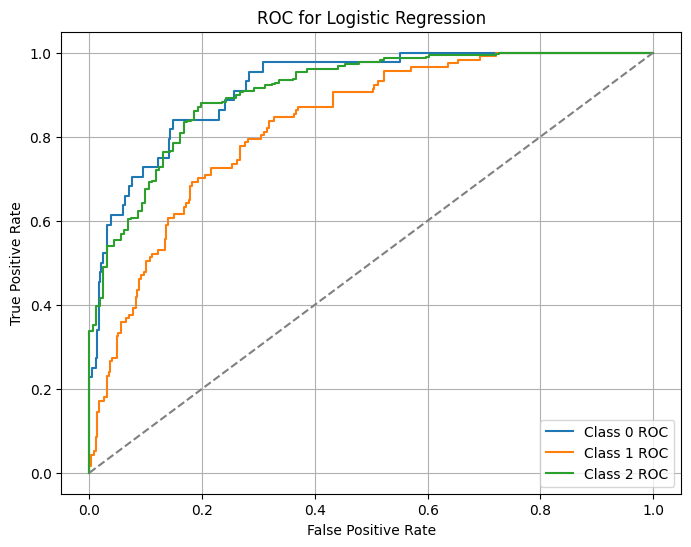

In [ ]:
# Evaluate the Logistic Regression model
evaluate_accuracy(final_logr, X_test_scaled, y_test, "Logistic Regression")

The Logistic Regression model achieved an overall accuracy of 78.46%, with a weighted precision of 0.7765, recall of 0.7846, and F1-score of 0.7779. The AUC-ROC score of 0.8858 reflects the model's strong ability to distinguish between classes, although it is lower than that of the Random Forest model. Class 2 showed the best performance, with a precision of 0.86, recall of 0.91, and F1-score of 0.88, benefiting from its larger support and clearer separability in the feature space. Class 1 displayed moderate performance, with a precision of 0.61 and recall of 0.59, indicating some challenges in distinguishing it from other classes. Class 0 had the lowest metrics, with a precision of 0.66 and recall of 0.43, suggesting the model struggles with this minority class, likely due to its smaller representation in the data.

The steepness of the AUC-ROC curves confirms these observations, with the curves for Classes 0 and 2 being steeper, reflecting the model's better ability to separate these classes from the others, though their relative steepness alternates. Class 1 had the least steep curve, consistent with its moderate performance. These results suggest that the Logistic Regression model provides reliable overall performance but struggles with minority class detection, especially for Class 0, highlighting its limitations in handling imbalanced datasets compared to more complex models like Random Forest.

In [ ]:
# Cross-validation for Logistic Regression
cross_validation_strat(final_logr, X_test_scaled, y_test, "Logistic Regression")


Cross-Validation Assessment for Logistic Regression (5-fold Stratified):

Accuracy: 0.7740
Precision: 0.7646
Recall: 0.7740
F1 Score: 0.7683
AUC-ROC: 0.8668

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        44
           1       0.61      0.56      0.58       117
           2       0.85      0.90      0.88       308

    accuracy                           0.77       469
   macro avg       0.67      0.64      0.65       469
weighted avg       0.76      0.77      0.77       469



The cross-validation results for the Logistic Regression model reveal a slight decline in performance compared to the single test set evaluation, indicating some variability in the model's robustness. The cross-validation accuracy dropped insignificantly from 78.46% to 77.4%, indicating consistent performance across different folds of the data. The AUC-ROC score barely increased from 0.8858 to 0.8868, suggesting that the original evaluation is a reasonable estimate of the model's real-world generalization ability. Class 2 maintained strong performance during cross-validation, with a precision of 0.85 and recall of 0.90, consistent with its dominance in both evaluations. However, Class 0 and Class 1 showed slightly weaker performance in cross-validation, with Class 0 maintaining a balanced but low F1 score (0.50), interestingly losing precision but increasing its recall score by 0.02. Class 1 saw a drop in recall compared to the original results, but it was not major (drop of 0.03).

The averaged metrics for accuracy, precision, recall, and AUC-ROC are very similar, all within a small margin of each other, indicating a decent level of robustness overall.

These findings suggest that while the model performs reasonably well overall, its performance on the minority classes can be inconsistent across different subsets of the data, though remarkably improving the minimization of false negatives for Class 0. This variability highlights the sensitivity of Logistic Regression to class imbalances and suggests that the model's predictions for the minority classes may not be as robust as initially indicated by the single test set evaluation.


## Optimal Random Forest Assessment

Assessment of Random Forest:
Accuracy: 0.8358
Precision: 0.8386
Recall: 0.8358
F1 Score: 0.8334
AUC-ROC: 0.9287

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72        44
           1       0.68      0.69      0.68       117
           2       0.89      0.93      0.91       308

    accuracy                           0.84       469
   macro avg       0.83      0.74      0.77       469
weighted avg       0.84      0.84      0.83       469



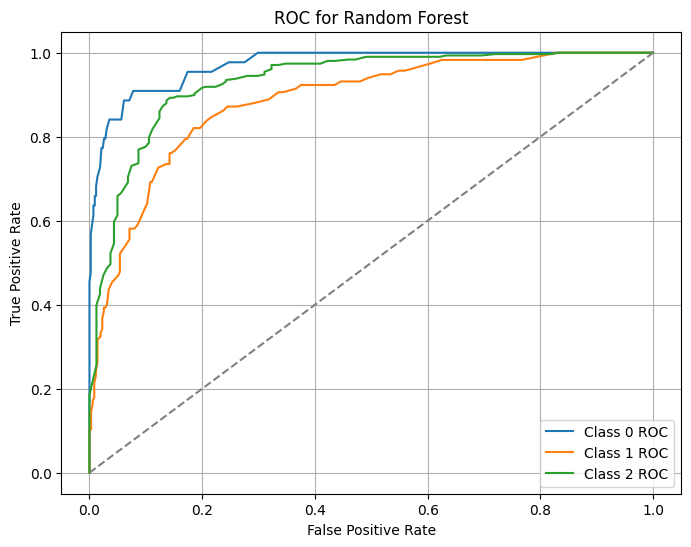

In [ ]:
# Evaluate the Random Forest model's accuracy
evaluate_accuracy(final_forest, X_test, y_test, "Random Forest")

The Random Forest model achieved a strong overall performance with an accuracy of 83.58%, a precision of 0.8386, a recall of 0.8358, and an F1 score of 0.8334. The high AUC-ROC score of 0.9287 reflects the model's excellent ability to distinguish between classes. Class 2 showed the best performance, with a precision of 0.89, recall of 0.93, and F1 score of 0.91, likely benefiting from its larger sample size and separability in the feature space. In contrast, Class 0 had strong precision (0.93) but a lower recall (0.59), indicating that while the model is confident in its predictions for this class, it struggles to capture all actual instances. Class 1 demonstrated moderate performance with a precision of 0.68 and recall of 0.69, suggesting some challenges in distinguishing it from other classes.

The AUC-ROC curves further highlight these trends, with Class 0 having the steepest curve, indicating high confidence in its predictions despite lower recall. Class 2's curve was also steep, reflecting its strong overall performance, while Class 1 had the least steep curve, revealing challenges in distinguishing it from other classes. These results suggest that the model performs well overall but struggles with minority class detection and overlaps in feature space, particularly for Class 1.

In [ ]:
# Cross-validation for Random Forest
cross_validation_strat(final_forest, X_test, y_test, "Random Forest")


Cross-Validation Assessment for Random Forest (5-fold Stratified):

Accuracy: 0.8102
Precision: 0.7993
Recall: 0.8102
F1 Score: 0.8014
AUC-ROC: 0.8884

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.43      0.52        44
           1       0.67      0.62      0.64       117
           2       0.87      0.94      0.90       308

    accuracy                           0.81       469
   macro avg       0.73      0.66      0.69       469
weighted avg       0.80      0.81      0.80       469



The cross-validation results for the Random Forest model indicate a slight drop in performance compared to the original model's evaluation on the test set. While the cross-validation accuracy (81.02%) and AUC-ROC score (0.8869) remain relatively strong, they are lower than the single test set evaluation (accuracy: 83.58%, AUC-ROC: 0.9287). This demonstrates that the model is not as robust to variation in the data, but it is still relatively acceptable, as the drop is not significant. Precision, recall, and F1 scores during cross-validation also show a pretty significant decline, suggesting that the model’s performance lacks consistency across different folds, even when stratifying to remedy class imbalances. Notably, the performance for Class 0 during cross-validation is lower, with a precision of 0.66 and a recall of 0.43, compared to precision of 0.93 and a recall of 0.59 on the test set. This drop reflects potential variability in how the model handles the minority class under different training-validation splits. Meanwhile, Class 2 remains the most robust, with high precision (0.87 on CV) and recall (0.94 on CV) across both evaluations. These results suggest that while the model is acceptably robust, its performance on classes like Class 0 is inconsistent, and its metrics from the test set evaluation may slightly overestimate its real-world performance.

#**Conclusion and Recommendations**

Before I begin with a more detailed analysis of the findings, let's first re-examine some of the coefficients of the Logistic Regression Model and check the Feature Importance chart for the Random Forest Model.

## Recap of Model Outputs

In [ ]:
# Coefficients of Logistic Regression Model
# Get the coefficients
coefficients = final_logr.coef_

# If it's a multiclass model, it will have one row of coefficients per class
# Create a DataFrame for better visualization
coefficients_df = pd.DataFrame(coefficients, columns=feature_names)

# Add class labels if available
if hasattr(final_logr, "classes_"):
    coefficients_df.index = [f"Class {cls}" for cls in final_logr.classes_]

# Print the DataFrame
print("Coefficients of Logistic Regression Model:")
print(coefficients_df)

Coefficients of Logistic Regression Model:
            unreg  unsubreg      assn   formov    dommov    speech    elecsd  \
Class 0  0.124950 -0.164886 -0.055019 -0.15686 -0.233296  0.086360  0.018872   
Class 1 -0.060183 -0.032838 -0.249421 -0.04391 -0.044879 -0.139194  0.061753   
Class 2 -0.064768  0.197724  0.304440  0.20077  0.278175  0.052834 -0.080625   

         rel_free     wecon     wopol  ...   wosoc_l   union_l    barg_l  \
Class 0 -0.206764 -0.271937 -0.015934  ...  0.005902 -0.089404  0.123391   
Class 1 -0.027447 -0.030839  0.166852  ...  0.073436  0.122680 -0.025050   
Class 2  0.234211  0.302777 -0.150918  ... -0.079338 -0.033276 -0.098342   

           hour_l   force_l   child_l    wage_l    safe_l  trafficking_l  \
Class 0 -0.113263  0.031556 -0.073601  0.014152 -0.067948      -0.047525   
Class 1  0.099118 -0.131952  0.171941  0.069798  0.109345      -0.025873   
Class 2  0.014145  0.100396 -0.098340 -0.083950 -0.041397       0.073398   

          trial_l  
Class 

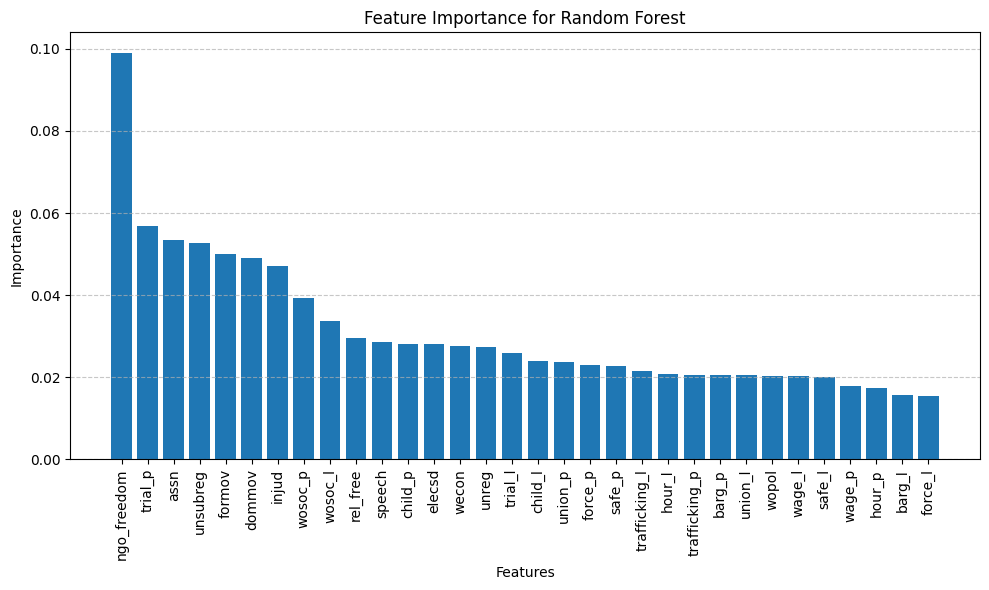

In [ ]:
# Feature importance of Random Forest Model
# Get feature importances
feature_importances = final_forest.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
sorted_features = [feature_names[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), sorted_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance for Random Forest")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Findings and Model Performance

The analysis explored two models, Random Forest and Logistic Regression, to identify predictors of physical integrity rights violations across countries, categorized into three classes: Class 0 (severe violations), Class 1 (moderate violations), and Class 2 (few violations). Both models provided valuable insights but exhibited differences in accuracy and robustness.

The Random Forest model demonstrated higher accuracy (83.58%) and AUC-ROC (0.9287) compared to the Logistic Regression model, which achieved an accuracy of 78.46% and AUC-ROC of 0.8858. This indicates that the Random Forest model was better at distinguishing between classes, likely due to its ability to capture complex, non-linear relationships in the data. However, the cross-validation accuracy for Random Forest dropped slightly to 81.02%, suggesting moderate variability in performance when tested across different data splits. Logistic Regression showed a less pronounced drop in cross-validation accuracy but a lower magnitude score (77.4%), still reflecting its robustness or lower sensitivity to data variability, implying decent generalizability on out-of-sample data.

These results suggest that while Random Forest is more accurate and robust overall, Logistic Regression provides interpretable coefficients that highlight key predictors for each class, which may be more useful in policymaking, as actors can better analyze the variables behind the coefficients (i.e. freedom of speech, labor laws)to outline strategies for preventing physical integrity rights abuses.

## Key Predictors and Class-Level Insights

The Random Forest model identified ngo_freedom, assn (freedom of association), trial_p (trial practices), and unsubreg (uncensored/unregulated political activity) as the most important predictors of physical integrity rights violations. These features consistently played a critical role in distinguishing between the three classes, emphasizing the importance of civil society and association rights in mitigating rights abuses.

The Logistic Regression model provided additional interpretability by highlighting the direction and magnitude of feature impacts. For Class 0 (severe violations), negative coefficients for domestic movement (dommov) (β=−0.233) and freedom of association (assn) (β=−0.055) suggest that restrictions in these areas strongly predict severe violations. These results align with the understanding that repressive regimes often limit civic freedoms to consolidate control, creating environments conducive to widespread abuse. In contrast, countries in Class 2 (few violations) showed positive coefficients for these variables (β=0.278 for dommov, and β=0.304 for assn), emphasizing the protective role of open civic spaces in safeguarding human rights. Class 1 (moderate violations) presented a transitional pattern, with weaker coefficients suggesting partial but inconsistent repression.

## Implications for the Social Sciences

These findings offer significant insights into the mechanisms driving physical integrity rights violations, with important implications for human rights research and policy. The strong association between civil society freedoms and rights outcomes underscores the critical role of NGO freedom, association rights, and movement freedoms in mitigating abuses. Countries with severe violations are often characterized by systematic repression of these freedoms, while those with fewer violations benefit from a more open civic space that enables accountability and public participation.

For policymakers and human rights advocates, these results highlight actionable intervention points. Supporting NGO operations and ensuring freedom of association and movement could significantly reduce the risk of severe rights violations. This is particularly crucial for countries transitioning between moderate and low levels of violations, where targeted interventions may help stabilize and improve conditions.

## Future Directions

Further studies could build on these findings to deepen the understanding of human rights violations. Longitudinal analyses could investigate how changes in civil society freedoms influence rights outcomes over time, while sub-national studies could explore localized patterns of violations. Additionally, examining interaction effects between key predictors, such as how restrictions on NGOs amplify the impact of movement limitations, could uncover deeper dynamics. Employing advanced models like gradient boosting or neural networks may refine predictions and capture complex relationships among predictors. These future directions would enhance both theoretical understanding and practical strategies for addressing physical integrity rights violations globally.